# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from dataclasses import dataclass, asdict
import itertools
from typing import List, Literal, Dict, Any, ClassVar, Tuple
import copy
import string

import seaborn

seaborn.set(palette="summer")

In [3]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/max509/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset("ag_news")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset["train"]["text"]):
    # Приводим к нижнему регистру и убираем пунктуацию
    proccessed_text = example.lower().translate(
        str.maketrans("", "", string.punctuation)
    )

    for word in word_tokenize(proccessed_text):
        words[word] += 1


vocab = set(["<unk>", "<bos>", "<eos>", "<pad>"])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f"Размер словаря: {len(vocab)}")

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind["<unk>"]
        self.bos_id = word2ind["<bos>"]
        self.eos_id = word2ind["<eos>"]
        self.pad_id = word2ind["<pad>"]

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = (
            self.data[idx]["text"]
            .lower()
            .translate(str.maketrans("", "", string.punctuation))
        )
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
        ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]["label"],
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[Dict[str, Any]],
    pad_id: int = word2ind["<pad>"],
    max_len: int = 256,
) -> torch.Tensor:
    seq_lens = [len(x["text"]) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence["text"] = sequence["text"][:max_seq_len]
        for _ in range(max_seq_len - len(sequence["text"])):
            sequence["text"].append(pad_id)

        new_batch.append(sequence["text"])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x["label"] for x in input_batch]).to(device)

    new_batch = {"input_ids": sequences, "label": labels}

    return new_batch

In [13]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

train_dataset = WordDataset(dataset["train"])


idx = np.random.choice(np.arange(len(dataset["test"])), 5000)
eval_dataset = WordDataset(dataset["test"].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size,
)

eval_dataloader = DataLoader(
    eval_dataset,
    shuffle=False,
    collate_fn=collate_fn_with_padding,
    batch_size=batch_size,
)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [8]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch["input_ids"])
            predictions.append(logits.argmax(dim=1))
            target.append(batch["label"])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Начало работы

Для решения задачи классификации с использованием рекуррентной сети был реализован класс модели `TextClassifier`.

In [9]:
@dataclass(frozen=True)
class RnnParams:
    hidden_size: int
    num_layers: int
    bidirectional: bool
    dropout: float


class TextClassifier(nn.Module):
    _RNN_TYPES: Dict[Literal["vanila", "gru", "lstm"], nn.Module] = {
        "vanila": nn.RNN,
        "gru": nn.GRU,
        "lstm": nn.LSTM,
    }

    def __init__(
        self,
        vocab_size: int,
        padding_idx: int,
        rnn_params: RnnParams,
        rnn_type: Literal["vanila", "gru", "lstm"],
        dropout: float,
        aggregation_type: Literal["mean", "max"],
        concat_with_last_token: bool,
        num_classes: int,
    ):
        """Text classifier based on RNN

        Args:
            vocab_size: size of tokens vocabulary
            padding_idx: index of padding token
            rnn_params: parameters of RNN layer, common for nn.RNN, nn.LSTM and nn.GRU
            rnn_type: type of RNN. Can be `vanila` (nn.RNN), `gru` (nn.GRU) and `lstm` (nn.LSTM)
            dropout: dropout probability for linear layer after RNN
            aggregation_type: type aggregation of RNN outputs for each token. Can be `max` or `mean`
            concat_with_last_token: if True, last token (and first when RNN is bidirectional)
            will be concatenated to aggregated RNN outputs
            num_classes: number of classes for classification
        """
        super().__init__()
        rnn_hidden_dim = rnn_params.hidden_size
        linear_dim = (
            (2 * rnn_hidden_dim) if rnn_params.bidirectional else rnn_hidden_dim
        )
        if concat_with_last_token:
            linear_dim *= 2
        self.embedding = nn.Embedding(
            vocab_size,
            rnn_hidden_dim,
            padding_idx=padding_idx,
        )
        self.rnn = self._RNN_TYPES[rnn_type](
            input_size=rnn_hidden_dim, batch_first=True, **asdict(rnn_params)
        )
        self.linear = nn.Linear(linear_dim, linear_dim)
        self.projection = nn.Linear(linear_dim, num_classes)

        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

        self.aggregation_type = aggregation_type
        self.concat_with_last_token = concat_with_last_token

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(inputs)  # [batch_size, seq_len, rnn_hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, linear_dim]

        if self.aggregation_type == "max":
            agg_output = output.max(dim=1)[0]  # [batch_size, linear_dim]
        elif self.aggregation_type == "mean":
            agg_output = output.mean(dim=1)  # [batch_size, linear_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        if self.concat_with_last_token:
            # If RNN bidirectional, agg output will be concatenated with last token of forward direction and first token of backward direction
            if self.rnn.bidirectional:
                forward_backward_output = output.view(
                    inputs.size(0), inputs.size(1), 2, -1
                )
                forward_last_token = forward_backward_output[:, -1, 0, :]
                backward_first_token = forward_backward_output[:, 0, 1, :]
                output = torch.concat(
                    (
                        agg_output,
                        forward_last_token,
                        backward_first_token,
                    ),
                    dim=-1,
                )  # [batch_size, linear_dim * 2]
            else:
                output = torch.concat(
                    (
                        agg_output,
                        torch.select(output, 1, -1),
                    ),
                    dim=-1,
                )  # [batch_size, linear_dim * 2]
        else:
            output = agg_output
        del agg_output

        output = self.dropout(
            self.linear(self.activation(output))
        )  # [batch_size, linear_dim]
        prediction = self.projection(
            self.activation(output)
        )  # [batch_size, num_classes]

        return prediction

In [10]:
def train_loop(
    train_dataloader: DataLoader,
    eval_dataloader: DataLoader,
    *,
    vocab_size: int,
    padding_idx: int,
    model_hparams: Dict[str, Any],
    epochs: int,
):
    print(f"Starting training for hparams: {model_hparams}")
    losses = []
    acc = []

    rnn_params = RnnParams(**model_hparams["rnn_params"])

    model = TextClassifier(
        vocab_size=vocab_size,
        padding_idx=padding_idx,
        rnn_params=rnn_params,
        rnn_type=model_hparams["rnn_type"],
        dropout=model_hparams["dropout"],
        aggregation_type=model_hparams["aggregation_type"],
        concat_with_last_token=model_hparams["concat_with_last_token"],
        num_classes=4,
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(
            tqdm(
                train_dataloader,
                desc=f"Training epoch {epoch}:",
            )
        ):
            optimizer.zero_grad()
            logits = model(batch["input_ids"])
            loss = criterion(logits, batch["label"])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        model.eval()
        acc.append(evaluate(model, eval_dataloader))

    return losses, acc

# Baseline model

В качестве бейзлайна была выбрана двунаправленная ванильная RNN (`nn.RNN`) с размерностью 256, 1 слоем. Выходы RNN агрегировались усреднением. Количество эпох равно 10

In [11]:
baseline_model_hparams = {
    "rnn_params": {
        "hidden_size": 256,
        "num_layers": 1,
        "bidirectional": True,
        "dropout": 0,
    },
    "rnn_type": "vanila",
    "dropout": 0.0,
    "aggregation_type": "mean",
    "concat_with_last_token": False,
}
baseline_epochs = 10

In [14]:
baseline_losses, baseline_acc = train_loop(
    train_dataloader,
    eval_dataloader,
    vocab_size=len(vocab),
    padding_idx=word2ind["<pad>"],
    model_hparams=baseline_model_hparams,
    epochs=baseline_epochs,
)

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 1, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'vanila', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

/tmp/ipykernel_172786/1903719085.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


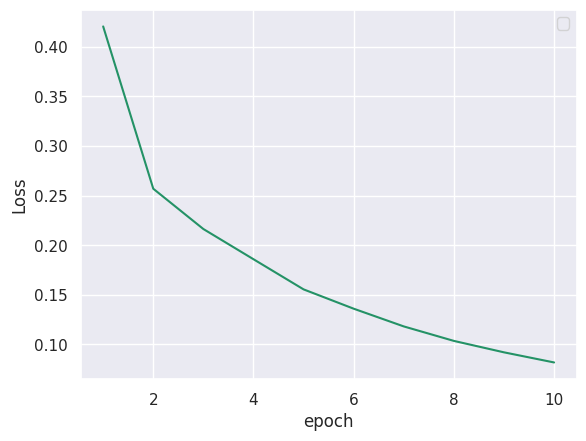

In [15]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(baseline_losses)) + 1, baseline_losses)
ax.set_ylabel("Loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

/tmp/ipykernel_172786/1570959391.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


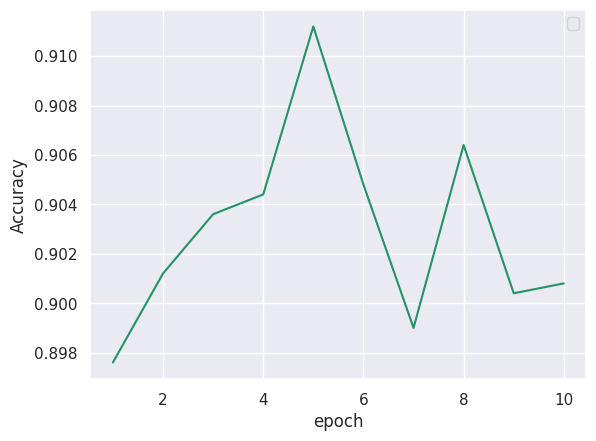

In [18]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(baseline_acc)) + 1, baseline_acc)
ax.set_ylabel("Accuracy")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [19]:
print(f"Best accuracy for baseline: {max(baseline_acc):.4f}")

Best accuracy for baseline: 0.9112


# RNN architecture selection

Первый эксперимент был связан с выбором архитектуры RNN

In [20]:
rnn_types = ["gru", "lstm"]

rnn_selection_results: Dict[str, Tuple[List[float], List[float]]] = dict()
for rnn_type in rnn_types:
    model_hparams = copy.deepcopy(baseline_model_hparams)
    model_hparams["rnn_type"] = rnn_type

    rnn_selection_results[rnn_type] = train_loop(
        train_dataloader,
        eval_dataloader,
        vocab_size=len(vocab),
        padding_idx=word2ind["<pad>"],
        model_hparams=model_hparams,
        epochs=baseline_epochs,
    )

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 1, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'gru', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 1, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

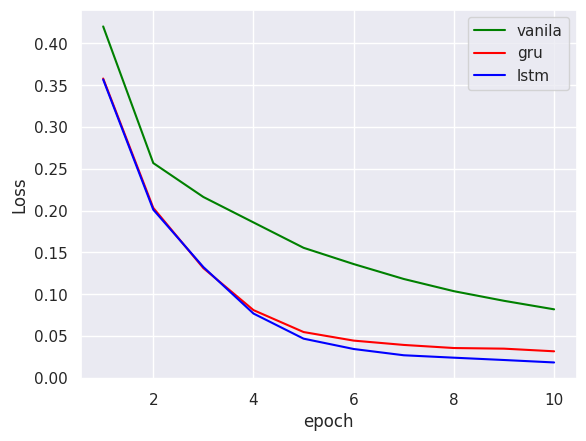

In [24]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(len(baseline_losses)) + 1,
    baseline_losses,
    label="vanila",
    color="green",
)
for rnn_type, color in zip(rnn_types, ["red", "blue"]):
    losses = rnn_selection_results[rnn_type][0]
    ax.plot(
        np.arange(len(losses)) + 1,
        losses,
        label=rnn_type,
        color=color,
    )
ax.set_ylabel("Loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

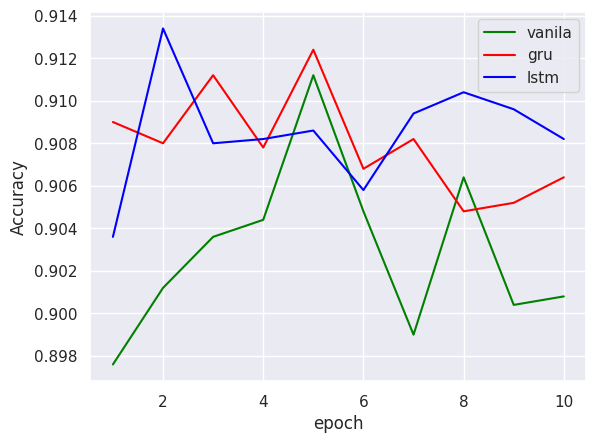

In [25]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(len(baseline_acc)) + 1,
    baseline_acc,
    label="vanila",
    color="green",
)
for rnn_type, color in zip(rnn_types, ["red", "blue"]):
    acc = rnn_selection_results[rnn_type][1]
    ax.plot(
        np.arange(len(acc)) + 1,
        acc,
        label=rnn_type,
        color=color,
    )
ax.set_ylabel("Accuracy")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [27]:
print(f"Best vanila RNN accuracy: {max(baseline_acc):.4f}")
print(f'Best GRU accuracy: {max(rnn_selection_results["gru"][1]):.4f}')
print(f'Best LSTM accuracy: {max(rnn_selection_results["lstm"][1]):.4f}')

Best vanila RNN accuracy: 0.9112
Best GRU accuracy: 0.9124
Best LSTM accuracy: 0.9134


Лучшей архитектурой оказалась LSTM

# Num layers selection

Следующий эксперимент был саязан с выбором оптимльного размера количества слоев RNN (в нашем случае - LSTM).

Так как количество слоев увеличивает количество обучаемых параметров модели, было также увеличено количество эпох обучения с 10 до 50

In [26]:
num_layers_hparams = [2, 3, 4, 5, 6]
num_layers_selection_epochs = 50  # We need to increase number of epochs because of models with more layer will be underfitted with small epochs count
num_layers_selection_results: Dict[int, Tuple[List[float], List[float]]] = dict()
for num_layers in num_layers_hparams:
    model_hparams = copy.deepcopy(baseline_model_hparams)
    model_hparams["rnn_type"] = "lstm"
    model_hparams["rnn_params"]["num_layers"] = num_layers

    num_layers_selection_results[num_layers] = train_loop(
        train_dataloader,
        eval_dataloader,
        vocab_size=len(vocab),
        padding_idx=word2ind["<pad>"],
        model_hparams=model_hparams,
        epochs=num_layers_selection_epochs,
    )

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 2, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 3, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 4, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 5, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 6, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/3750 [00:00<?, ?it/s]

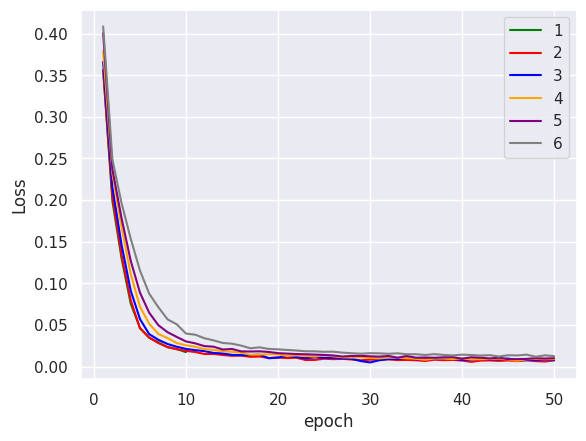

In [27]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(len(rnn_selection_results["lstm"][0])) + 1,
    rnn_selection_results["lstm"][0],
    label="1",
    color="green",
)
for num_layers, color in zip(
    [2, 3, 4, 5, 6], ["red", "blue", "orange", "purple", "gray"]
):
    loss = num_layers_selection_results[num_layers][0]
    ax.plot(np.arange(len(loss)) + 1, loss, label=num_layers, color=color)
ax.set_ylabel("Loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

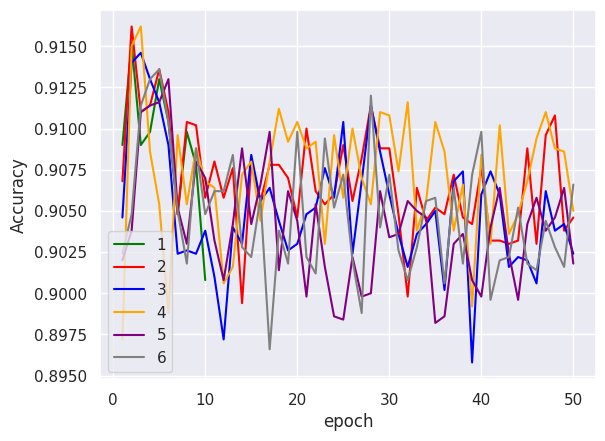

In [28]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(len(rnn_selection_results["lstm"][1])) + 1,
    rnn_selection_results["lstm"][1],
    label="1",
    color="green",
)
for num_layers, color in zip(
    num_layers_hparams, ["red", "blue", "orange", "purple", "gray"]
):
    acc = num_layers_selection_results[num_layers][1]
    ax.plot(np.arange(len(acc)) + 1, acc, label=num_layers, color=color)
ax.set_ylabel("Accuracy")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [28]:
print(f"Max accuracy for num_layers=1: {max(rnn_selection_results['lstm'][1]):.4f}")
for num_layers in num_layers_hparams:
    print(
        f"Max accuracy for num_layers={num_layers}: {max(num_layers_selection_results[num_layers][1]):.4f}"
    )

Max accuracy for num_layers=1: 0.9134
Max accuracy for num_layers=2: 0.9162
Max accuracy for num_layers=3: 0.9146
Max accuracy for num_layers=4: 0.9162
Max accuracy for num_layers=5: 0.9130
Max accuracy for num_layers=6: 0.9136


По графику accuracy видно, что начиная с ~8 эпох качество модели было ниже пикового, и это означает, что оптимальное количество эпох точно <8. Также модели с 2 и 4 слоями RNN показали лучшее качество, хотя это качество не сильно улучшилось по сравнению с моделью с 1 слоем. 

Была выбрана более простая модель, дающая лучшее качество, то есть модель с 2 слоями

# Aggregation selection

Этот эксперимент связян с выбором типа агрегации выходов LSTM для каждого токена, а также с добавлением или нет выхода LSTM для крайних токенов к результату агрегации.

В случае `bidirectional=True` и `concat_with_last_token=True` к результату агрегации добавится последний токен для forward прохождения последовательности, а также первый токен для backward прохождения. Такое решение было принято в предположении, что последний токен forward прохождения и первый токен backward прохождения накопят информацию о последовательности, что поможет модели для вытаскивания какой-либо суммарной информации о тексте

In [36]:
aggregation_type_hparams = ["max", "mean"]
cocnat_with_last_token_hparams = [False, True]
aggregation_selection_results: Dict[
    Tuple[str, bool], Tuple[List[float], List[float]]
] = dict()
for (
    aggregation_type,
    concat_with_last_token,
) in itertools.product(aggregation_type_hparams, cocnat_with_last_token_hparams):
    model_hparams = copy.deepcopy(baseline_model_hparams)
    model_hparams["rnn_type"] = "lstm"
    model_hparams["rnn_params"]["num_layers"] = 2
    model_hparams["aggregation_type"] = aggregation_type
    model_hparams["concat_with_last_token"] = concat_with_last_token

    aggregation_selection_results[(aggregation_type, concat_with_last_token)] = (
        train_loop(
            train_dataloader,
            eval_dataloader,
            vocab_size=len(vocab),
            padding_idx=word2ind["<pad>"],
            model_hparams=model_hparams,
            epochs=baseline_epochs,
        )
    )

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 2, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'max', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 2, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'max', 'concat_with_last_token': True}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 2, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': False}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for hparams: {'rnn_params': {'hidden_size': 256, 'num_layers': 2, 'bidirectional': True, 'dropout': 0}, 'rnn_type': 'lstm', 'dropout': 0.0, 'aggregation_type': 'mean', 'concat_with_last_token': True}


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

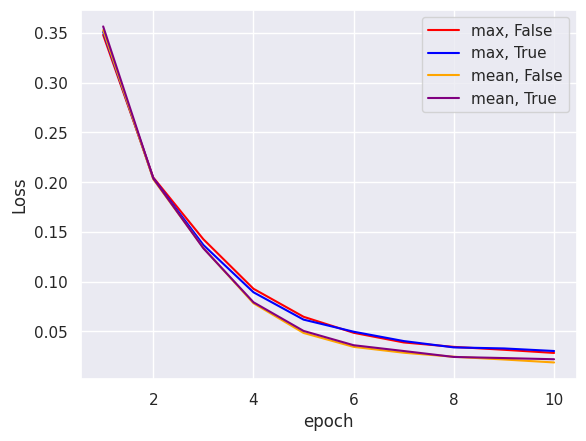

In [40]:
fig, ax = plt.subplots()
for (
    aggregation_type,
    concat_with_last_token,
), color in zip(
    itertools.product(
        aggregation_type_hparams,
        cocnat_with_last_token_hparams,
    ),
    ["red", "blue", "orange", "purple"],
):
    loss = aggregation_selection_results[(aggregation_type, concat_with_last_token)][0]
    ax.plot(
        np.arange(len(loss)) + 1,
        loss,
        label=f"{aggregation_type}, {concat_with_last_token}",
        color=color,
    )
ax.set_ylabel("Loss")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

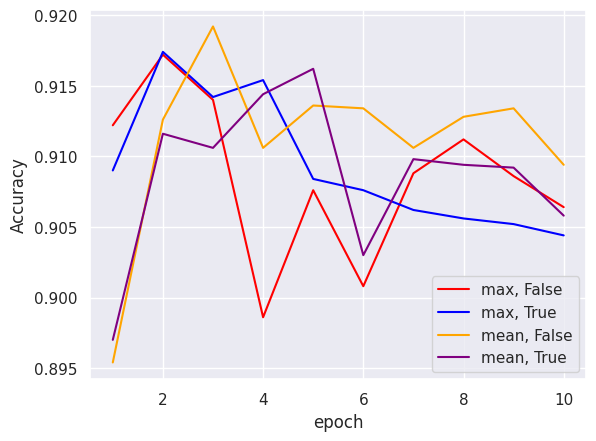

In [39]:
fig, ax = plt.subplots()
for (
    aggregation_type,
    concat_with_last_token,
), color in zip(
    itertools.product(
        aggregation_type_hparams,
        cocnat_with_last_token_hparams,
    ),
    ["red", "blue", "orange", "purple"],
):
    acc = aggregation_selection_results[(aggregation_type, concat_with_last_token)][1]
    ax.plot(
        np.arange(len(acc)) + 1,
        acc,
        label=f"{aggregation_type}, {concat_with_last_token}",
        color=color,
    )
ax.set_ylabel("Accuracy")
ax.set_xlabel("epoch")
ax.legend()
plt.show()

In [45]:
for (
    aggregation_type,
    concat_with_last_token,
) in itertools.product(aggregation_type_hparams, cocnat_with_last_token_hparams):
    print(
        f"Max accuracy for aggregation_type={aggregation_type} and concat_with_last_token={concat_with_last_token}: "
        f"{max(aggregation_selection_results[(aggregation_type, concat_with_last_token)][1]):.4f}"
    )

Max accuracy for aggregation_type=max and concat_with_last_token=False: 0.9172
Max accuracy for aggregation_type=max and concat_with_last_token=True: 0.9174
Max accuracy for aggregation_type=mean and concat_with_last_token=False: 0.9192
Max accuracy for aggregation_type=mean and concat_with_last_token=True: 0.9162


In [50]:
best_accuracy = max(aggregation_selection_results[("mean", False)][1])

Агрегация с типом `mean` и без конкатенации последнего токена показала наилучший вариант, то есть этот эксперимент не показал улучшения

# Best model

In [61]:
print(
    "Лучшая модель оказалась с архитектурой LSTM, количеством слоев 2, агрегацией mean и без конкатенации"
)
print(f"Лучшее accuracy: {best_accuracy:.4f}")

Лучшая модель оказалась с архитектурой LSTM, количеством слоев 2, агрегацией mean и без конкатенации
Лучшее accuracy: 0.9192


## Отчет
* Эксперименты с выбором архитектуры RNN и количеством слоев RNN принесли улучшение качества, а эксперимент с изменением типа агрегации выхода LSTM - нет
* Модели со всеми архитектурами RNN (vanila, LSTM и GRU) достигают пикового качества на количестве эпох <7, а далее модели уже переобучиваются и у них понижается среднее качетсво модели, при это само качество колеблется в зависимости от эпохи, если эпоха > 8
* Лучшая модель оказалась с архитектурой LSTM, количеством слоев 2, агрегацией mean и без конкатенации